# Create map of parcel data and buildings

In [1]:
# set up
import os
import geopandas
import matplotlib.pyplot as plt
import numpy as np

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot as rioplot

os.chdir("../data/")

In [2]:
# load data
parcels = geopandas.read_file('Parcels_FY19')
buildings = geopandas.read_file('Buildings')

# Exploratory maps 

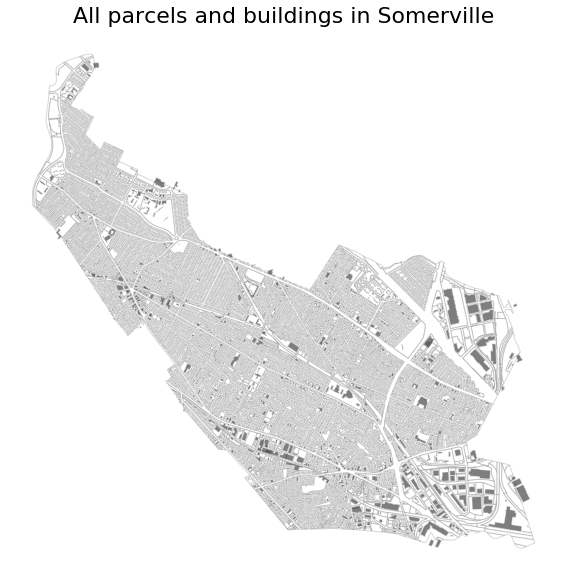

In [3]:
fig, ax = plt.subplots(figsize=(20,10))
parcels.plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
buildings.plot(ax=ax, color='black', edgecolor='white', alpha=0.5)
plt.title("All parcels and buildings in Somerville", fontsize=22)
plt.axis('off');

It's hard to make sense of this, so let's zoom in on a street.

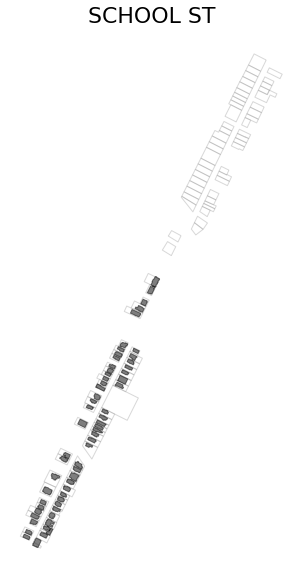

In [4]:
STREET = 'SCHOOL ST'

fig, ax = plt.subplots(figsize=(20,10))
parcels[parcels['Street'] == STREET].plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
buildings[buildings['Street'] == STREET].plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
plt.title(STREET, fontsize=22)
plt.axis('off');

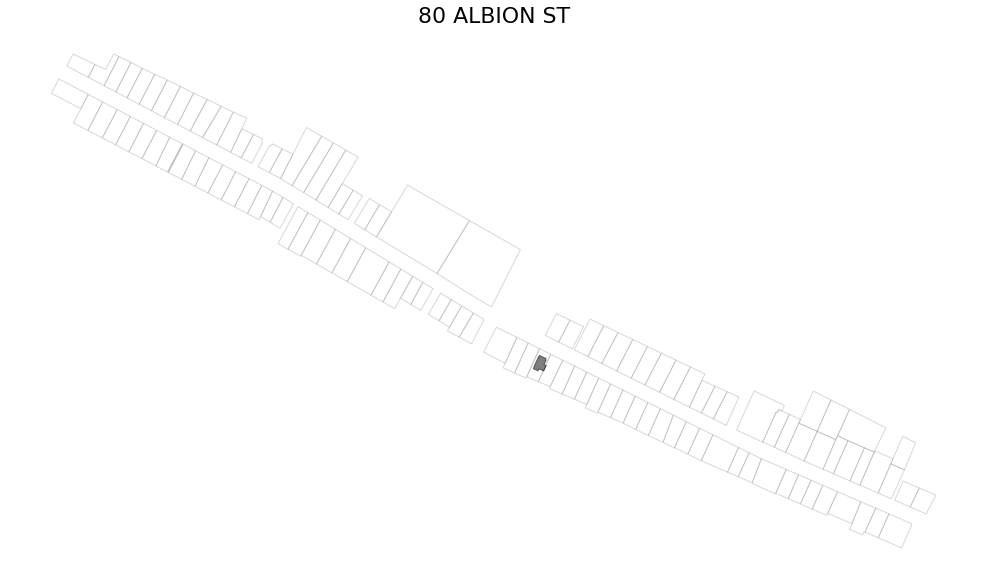

In [5]:
ADDRESS_NUM = '80'
STREET = 'ALBION ST'

fig, ax = plt.subplots(figsize=(20,10))
#parcels[(parcels['Street'] == STREET) & (parcels['AddNum']==ADDRESS_NUM)].plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
parcels[(parcels['Street'] == STREET)].plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
buildings[(buildings['Street'] == STREET) & (buildings['AddNum']==ADDRESS_NUM)].plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
plt.title(ADDRESS_NUM + " " + STREET, fontsize=22)
plt.axis('off');

# Overlaying parcels and buildings on .tiff

In [6]:
# get projection of parcels to use to re-project raster
dest_crs = parcels.crs['init']
print(dest_crs)

epsg:2249


In [7]:
def rio_reproject(inpath, outpath, new_crs):
    
    '''
    Reproject raster file into a new coordinate system and save it as a new file. 
    Function borrowed from this blog post on earthdatascience.org:
    https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/
    
    Inputs
    ======
    inpath : str
        File path of original raster (to load).
    outpath : str
        File path for new raster (to save).
    new_crs : str
        Coordinate system understood by rasterio, such as epsg:2249.
    
    Output
    ======
    None
    '''
    
    dst_crs = new_crs 

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [8]:
rio_reproject(inpath='tiff/somerville.tif', outpath='tiff/somerville_reprojected.tif', new_crs=dest_crs)

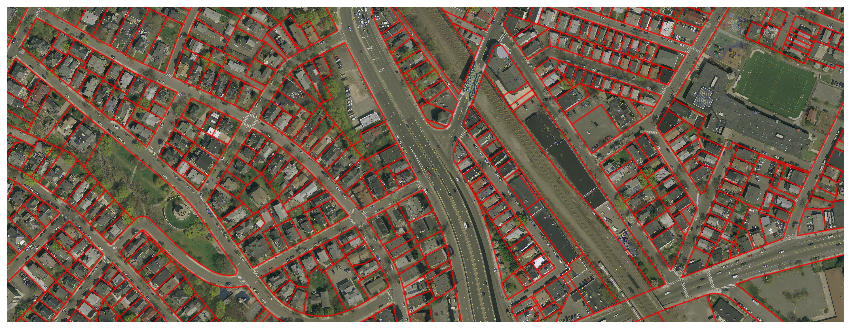

In [84]:
somerville_raster = rio.open('tiff/somerville_reprojected.tif')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
rioplot.show((somerville_raster, [1,2,3]), ax=ax) # all 3 color channels
parcels.plot(ax=ax, facecolor='none', edgecolor='r', alpha=0.7)
ax.set_xlim([somerville_raster.bounds.left, somerville_raster.bounds.right])
ax.set_ylim([somerville_raster.bounds.bottom, somerville_raster.bounds.top])
plt.axis('off');

somerville_raster.close()

# Iterating across parcels to grab tiff

   OBJECTID Map Block Lot     MBL PolyType AddNum    Street AddNum2 Street2  \
0         1  19     F   1  19-F-1   PARCEL    838  BROADWAY    None    None   

  AddNum3 Street3 SublotOf TaxParMBL   Shape_Leng     Shape_Area  \
0    None    None     None    19-F-1  2133.460536  197502.465873   

                                            geometry  
0  (POLYGON ((759940.058133468 2971010.939469054,...  
   OBJECTID Map Block Lot     MBL PolyType AddNum         Street AddNum2  \
1         2  54     D   5  54-D-5   PARCEL    393  WASHINGTON ST    None   

  Street2 AddNum3 Street3 SublotOf TaxParMBL  Shape_Leng  Shape_Area  \
1    None    None    None     None    54-D-5  316.130596  2397.40254   

                                            geometry  
1  (POLYGON ((762784.5485074669 2963229.330360398...  
   OBJECTID Map Block Lot      MBL PolyType AddNum        Street AddNum2  \
2         3  85     A  14  85-A-14   PARCEL      0  ASSEMBLY ROW    None   

  Street2 AddNum3 Street3 SublotO

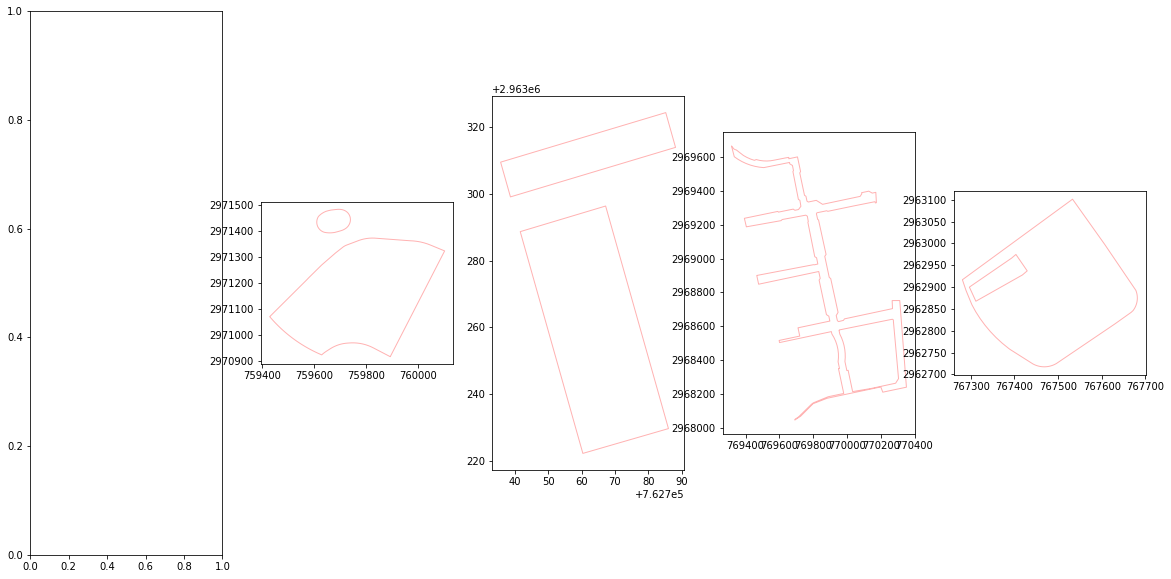

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,10))

for i in range(4):#range(parcels.shape[0]):
    print(parcels.loc[[i]])
    parcels.loc[[i]].plot(ax=ax[i+1], facecolor='none', edgecolor='r', alpha=0.3)
    